In [2]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
# from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from wordcloud import WordCloud
import twint
import nest_asyncio

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

nest_asyncio.apply()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\berns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berns\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
#gather tweets from Elon banning the Twitter API
c = twint.Config()
c.Search = "Twitter API"
c.Limit = 10000
c.Since = "2023-02-02" 
# c.Until = "2023-02-03"
c.Pandas = True

# Uncommonet the following line to run
# twint.run.Search(c)

#convert data into a dataframe
twitter_api = twint.storage.panda.Tweets_df
twitter_api.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1621319912135299072,1621219302769655811,1.675388e+12,2023-02-02 20:29:24,-0500,,@Asriel_Universe Por exemplo: Com a API do twi...,pt,[],[],...,,,,,,"[{'screen_name': 'Asriel_Universe', 'name': '𝙰...",,,,
1,1621319897388122114,1621319897388122114,1.675388e+12,2023-02-02 20:29:20,-0500,,if twitter api becomes monetized this website ...,en,[],[],...,,,,,,[],,,,
2,1621319888798375936,1621319888798375936,1.675388e+12,2023-02-02 20:29:18,-0500,,ちょ、TwitterAPIが有料化か…💦 まぁ、今まで恩恵を受けてた身だから、ランニングコス...,ja,[twitterapi],[],...,,,,,,[],,,,
3,1621319880715960323,1621046654299426816,1.675388e+12,2023-02-02 20:29:16,-0500,,イーロンマスクが「~$100」と言っていた、Twitter APIの価格設定が収益化していな...,ja,[],[],...,,,,,,[],,,,
4,1621319878509744128,1621046654299426816,1.675388e+12,2023-02-02 20:29:16,-0500,,今回の件でTwitter APIを使った面白いツールやアプリがたくさん消えちゃうことになった...,ja,[],[],...,,,,,,[],,,,


In [6]:
twitter_api.shape

(10014, 38)

In [7]:
# filter for tweets in English
twitter_api_eng = twitter_api[twitter_api['language'] == 'en']

In [34]:
#tokenizing each tweet
tokenized_tweets = []
for tweet in twitter_api_eng['tweet']:
    tokenized_tweets.append(tokenizer.tokenize(tweet.lower())) #making all tweets lowercase so no word is duplicated later on
    
# print(tokenized_tweets)

In [41]:
tokenized_tweets[:2]

[['if',
  'twitter',
  'api',
  'becomes',
  'monetized',
  'this',
  'website',
  'is',
  'as',
  'cooked',
  'as',
  'netflix'],
 ['well',
  'the',
  'twitter',
  'api',
  'thing',
  'sucks',
  'because',
  'i',
  'used',
  'it',
  'to',
  'get',
  'the',
  'tweets',
  'i',
  'retweeted',
  'from',
  'here',
  'for',
  'a',
  'bot',
  'that',
  'posts',
  'them',
  'at',
  'random',
  'on',
  'demand',
  'nevertheless',
  'dragons',
  'will',
  'continue',
  'to',
  'be',
  'posted']]

In [46]:
#creating a stop words list - these words don't add much value
from nltk.corpus import stopwords
import string

#adding additional words I don't find to be that valuable
additional_stopwords = ['https', 'I', 'com', 'http', 'RT', 'co', 'the', 'amp', 'the', 'lt', 'A', 'www', 'rt', 'got', 'get', 
                        'ly', 'u', '9', '1', 'one', 'would']

stopwords_list = stopwords.words('english')

stopwords_list += list(string.punctuation)

stopwords_list += additional_stopwords

# print(stopwords_list)

In [47]:
#isolate every word
tweets = []
for tweet in tokenized_tweets:
    for word in tweet:
        if word not in stopwords_list:
            tweets.append(word)  

In [48]:
#freqDist - frequency of words
fdist = FreqDist(tweets)

In [49]:
#finding the 25 most common words
fdist.most_common(50)

[('twitter', 6914),
 ('api', 6088),
 ('access', 1617),
 ('free', 1278),
 ('use', 959),
 ('bots', 885),
 ('like', 790),
 ('bot', 760),
 ('pay', 687),
 ('going', 575),
 ('make', 475),
 ('account', 473),
 ('paid', 462),
 ('people', 440),
 ('stop', 426),
 ('developers', 405),
 ('charging', 398),
 ('february', 383),
 ('changes', 361),
 ('new', 358),
 ('see', 347),
 ('tweet', 344),
 ('using', 344),
 ('accounts', 341),
 ('elon', 311),
 ('twitterdev', 310),
 ('thing', 307),
 ('money', 291),
 ('week', 284),
 ('apps', 281),
 ('elonmusk', 277),
 ('posting', 277),
 ('data', 277),
 ('longer', 275),
 ('twitterapi', 274),
 ('due', 262),
 ('tweets', 257),
 ('means', 253),
 ('many', 247),
 ('mastodon', 247),
 ('gonna', 247),
 ('think', 240),
 ('party', 237),
 ('still', 237),
 ('app', 235),
 ('post', 234),
 ('change', 232),
 ('even', 232),
 ('used', 229),
 ('know', 225)]

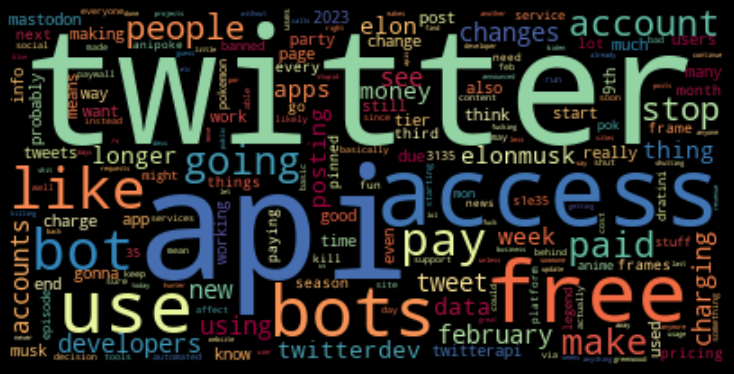

<Figure size 432x288 with 0 Axes>

In [52]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(fdist)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# Uncomment the next line if you want to save your image:
plt.savefig('elon.png')

In [30]:
# twitter_api_eng['tweet'].dtypes

In [31]:
# tokenized_tweets[:2]

In [32]:
# type(tokenized_tweets)

In [33]:
# tokenizer.tokenize(tokenized_tweets)

In [ ]:
#gather tweets from Elon banning the Twitter API
c = twint.Config()
c.Search = "elon"
c.Limit = 25000
c.Since = "2023-02-02" 
# c.Until = "2023-02-03"
c.Pandas = True

# Uncommonet the following line to run
# twint.run.Search(c)

#convert data into a dataframe
elon = twint.storage.panda.Tweets_df

# filter for tweets in English
elon_f = elon[elon['language'] == 'en']

elon_f.head()

In [ ]:
#tokenizing each tweet
tokenized_tweets = []
for tweet in elon['tweet']:
    tokenized_tweets.append(tokenizer.tokenize(tweet.lower())) #making all tweets lowercase so no word is duplicated later on

In [ ]:
#isolate every word
tweets = []
for tweet in tokenized_tweets:
    for word in tweet:
        if word not in stopwords_list:
            tweets.append(word)  

In [ ]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Pastel1').generate_from_frequencies(fdist)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# Uncomment the next line if you want to save your image:
plt.savefig('elonsucks.png')

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
elon_f['vader_score'] = elon_f['tweet'].apply(lambda x: vader.polarity_scores(x))
elon_f['vader_score']

In [ ]:
#add vader scores into the Inception dataframe
elon_f['positive sentiment score'] = elon_f['tweet'].apply(lambda x: vader.polarity_scores(x)['pos'])
elon_f['negative sentiment score'] = elon_f['tweet'].apply(lambda x: vader.polarity_scores(x)['neg'])
elon_f['neutral sentiment score'] = elon_f['tweet'].apply(lambda x: vader.polarity_scores(x)['neu'])
elon_f['compound sentiment score'] = elon_f['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])
elon_f.head()

In [ ]:
#distribution of vader score
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.distplot(elon_f['vader_score'], color = 'firebrick')
plt.xlabel('Sentiment Score', fontsize=18)
plt.ylabel('Tweets per Score', fontsize=18)
plt.title('VADER Sentiment of Elon Today', fontsize=22)
plt.tick_params(labelsize='large')